In [1]:
import awkward as awk
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
plt.style.use("../figures.mplstyle")
import numpy as np

In [2]:
filename = {"MINERvA":"MINERvA_Dipole_M4.70e-01_mu1.25e-06_example.parquet",
            "MiniBooNE":"MiniBooNE_Dipole_M4.70e-01_mu1.25e-06_example.parquet",
            "CCM":"CCM_Dipole_M2.35e-02_mu3.00e-07_example.parquet"}

POT = {"MINERvA":11.6e20,
       "MiniBooNE":18.75e20,
       "CCM":2.25e22}

Emax = {"MINERvA":20,
        "MiniBooNE":5,
        "CCM":0.04}

axis = {"MINERvA":3,
        "MiniBooNE":3,
        "CCM":1}

xrange = {"MINERvA":[-2,2],
          "MiniBooNE":[-8,8],
          "CCM":[-5,25]}

yrange = {"MINERvA":[-2,2],
          "MiniBooNE":[-8,8],
          "CCM":[-3,3]}

zrange = {"MINERvA":[-10,10],
          "MiniBooNE":[-8,8],
          "CCM":[-3,3]}

ylim_E = {"MINERvA":[1e1,9e5],
          "MiniBooNE":[1e0,1e4],
          "CCM":[1e-3,1e6]}

ylim_C = {"MINERvA":[1e1,5e6],
          "MiniBooNE":[1e-1,1e5],
          "CCM":[1e-3,1e6]}


In [3]:
# Kinematic distributions

def plot_kinematics(data,POT,Emax,axis,ylim_E=None,ylim_C=None,nbins=30,savestr=None):
    
    fig,ax = plt.subplots(1,2,figsize=(16,6))
    ax[0].set_prop_cycle(color=['red', 'green', 'blue', 'orange'])
    ax[1].set_prop_cycle(color=['red', 'green', 'blue', 'orange'])
    
    dec_flag = data["primary_type"]=="ParticleType.N4"
    fid_flag = data["in_fiducial"][dec_flag]
    
    # initial nu
    nu_flag = data["primary_type"]=="ParticleType.NuMu"
    nu_momenta = np.squeeze(data["primary_momentum"][nu_flag])

    # N
    N_flag = data["primary_type"]=="ParticleType.N4"
    N_momenta = np.squeeze(data["primary_momentum"][N_flag])

    # gamma
    gamma_flag = data["secondary_types"]=='ParticleType.Gamma'
    gamma_momenta = data["secondary_momenta"][gamma_flag]
    # mask out entries that are not gamma
    gamma_momenta = awk.mask(gamma_momenta, awk.num(gamma_momenta,axis=2)>0)
    gamma_momenta = np.squeeze(gamma_momenta[~awk.is_none(gamma_momenta,axis=1)])

    # nu out
    nuout_flag = data["secondary_types"]=='ParticleType.NuLight'
    nuout_momenta = data["secondary_momenta"][nuout_flag]
    # mask out entries that are not nuout
    nuout_momenta = awk.mask(nuout_momenta, awk.num(nuout_momenta,axis=2)>0)
    nuout_momenta = np.squeeze(nuout_momenta[~awk.is_none(nuout_momenta,axis=1)])

    kwargs = {"bins":np.linspace(0,Emax,nbins),
              "weights":data["event_weight"]*POT,
              "histtype":"step"}

    # Energy
    n,_,_ = ax[0].hist(nu_momenta[:,0],**kwargs,label=r"Initial $\nu$")
    ax[0].hist(N_momenta[:,0],**kwargs,label=r"Upscattered $\mathcal{N}$")
    ax[0].hist(gamma_momenta[:,0],**kwargs,label=r"Outgoing $\gamma$")
    ax[0].hist(nuout_momenta[:,0],**kwargs,label=r"Outgoing $\nu$")
    
    # Angle
    def CosTheta(momenta):
        return momenta[:,axis]/np.linalg.norm(momenta[:,1:],axis=-1)
    
    kwargs["bins"] = np.linspace(-1,1,nbins)
    
    m,_,_ = ax[1].hist(CosTheta(nu_momenta),**kwargs,label=r"Initial $\nu$")
    ax[1].hist(CosTheta(N_momenta),**kwargs,label=r"Upscattered $\mathcal{N}$")
    ax[1].hist(CosTheta(gamma_momenta),**kwargs,label=r"Outgoing $\gamma$")
    ax[1].hist(CosTheta(nuout_momenta),**kwargs,label=r"Outgoing $\nu$")
    
    # fiducial events
    
    kwargs["ls"] = "--"
    kwargs["weights"]=kwargs["weights"]*fid_flag
    kwargs["bins"] = np.linspace(0,Emax,nbins)
    
    # Energy [fiducial]
    ax[0].hist(nu_momenta[:,0],**kwargs)
    ax[0].hist(N_momenta[:,0],**kwargs)
    ax[0].hist(gamma_momenta[:,0],**kwargs)
    ax[0].hist(nuout_momenta[:,0],**kwargs)
    
    kwargs["bins"] = np.linspace(-1,1,nbins)
    
    ax[1].hist(CosTheta(nu_momenta),**kwargs)
    ax[1].hist(CosTheta(N_momenta),**kwargs)
    ax[1].hist(CosTheta(gamma_momenta),**kwargs)
    ax[1].hist(CosTheta(nuout_momenta),**kwargs)
    
    ax[0].plot([],[],label="All Events",color="black")
    ax[0].plot([],[],ls="--",label="Fiducial Events",color="black")
    
    ax[0].legend(loc="upper left",ncol=3)
    ax[0].semilogy()
    ax[0].set_xlabel("Energy [GeV]")
    ax[0].set_ylabel("Event Rate in %2.2e POT"%POT)
    ax[0].set_xlim(0,Emax)
    if ylim_E is not None:
        ax[0].set_ylim(ylim_E)
    
    ax[1].plot([],[],label="All Events",color="black")
    ax[1].plot([],[],ls="--",label="Fiducial Events",color="black")
    
    ax[1].legend(loc="upper left",ncol=3)
    ax[1].semilogy()
    ax[1].set_xlabel(r"$\cos \theta$")
    ax[1].set_ylabel("Event Rate in %2.2e POT"%POT)
    ax[1].set_xlim(-1,1)
    if ylim_C is not None:
        ax[1].set_ylim(ylim_C)
        
    plt.tight_layout()
    if savestr is not None:
        plt.savefig(savestr+"_kinematics.pdf",dpi=100)
    
    plt.show()

In [4]:
def position_plot(x,y,bins,labelx,labely,title):
    plt.hist2d(x,y,bins=bins,norm=LogNorm())
    c = plt.colorbar()
    c.set_label("Number of Generated Events")
    plt.xlabel(labelx)
    plt.ylabel(labely)
    plt.text(bins[0][1],bins[1][-4],
             title,
             fontsize=14,
             bbox=dict(boxstyle="round",
                       ec="black",
                       fc="white")
            )
    plt.tight_layout()
    

def plot_positions(data,range1,range2,slice1="x",slice2="y",savestr=None):
    
    dec_flag = data["primary_type"]=="ParticleType.N4"
    fid_flag = data["in_fiducial"][dec_flag]
    
    fid_vertex = data["vertex"][data["in_fiducial"]][fid_flag]
    # mask out entries that are not fiducial
    fid_vertex = awk.mask(fid_vertex, awk.num(fid_vertex,axis=1)>0)
    fid_vertex = np.array(np.squeeze(fid_vertex[~awk.is_none(fid_vertex,axis=0)]))
    
    axis1 = {"x":0,"y":1,"z":2}[slice1]
    axis2 = {"x":0,"y":1,"z":2}[slice2]
    
    bins = (np.linspace(range1[0],range1[1],50),
            np.linspace(range2[0],range2[1],50))
    
    position_plot(np.array(data["vertex"][~dec_flag][:,0,axis1]),
                  np.array(data["vertex"][~dec_flag][:,0,axis2]),
                  bins,"%s [m]"%slice1,"%s [m]"%slice2,"Upscattering Vertex")
    if savestr is not None:
        plt.savefig(savestr+"_upscattering_vertex_%s%s.pdf"%(slice1,slice2),dpi=100)
    plt.show()
    
    position_plot(np.array(data["vertex"][dec_flag][:,0,axis1]),
                  np.array(data["vertex"][dec_flag][:,0,axis2]),
                  bins,"%s [m]"%slice1,"%s [m]"%slice2,"Decay Vertex")
    if savestr is not None:
        plt.savefig(savestr+"_decay_vertex_%s%s.pdf"%(slice1,slice2),dpi=100)
    plt.show()
    
    position_plot(fid_vertex[:,axis1],
                  fid_vertex[:,axis2],
                  bins,"%s [m]"%slice1,"%s [m]"%slice2,"Decay Vertex (Fiducial)")
    if savestr is not None:
        plt.savefig(savestr+"_fiducial_decay_vertex_%s%s.pdf"%(slice1,slice2),dpi=100)
    plt.show()

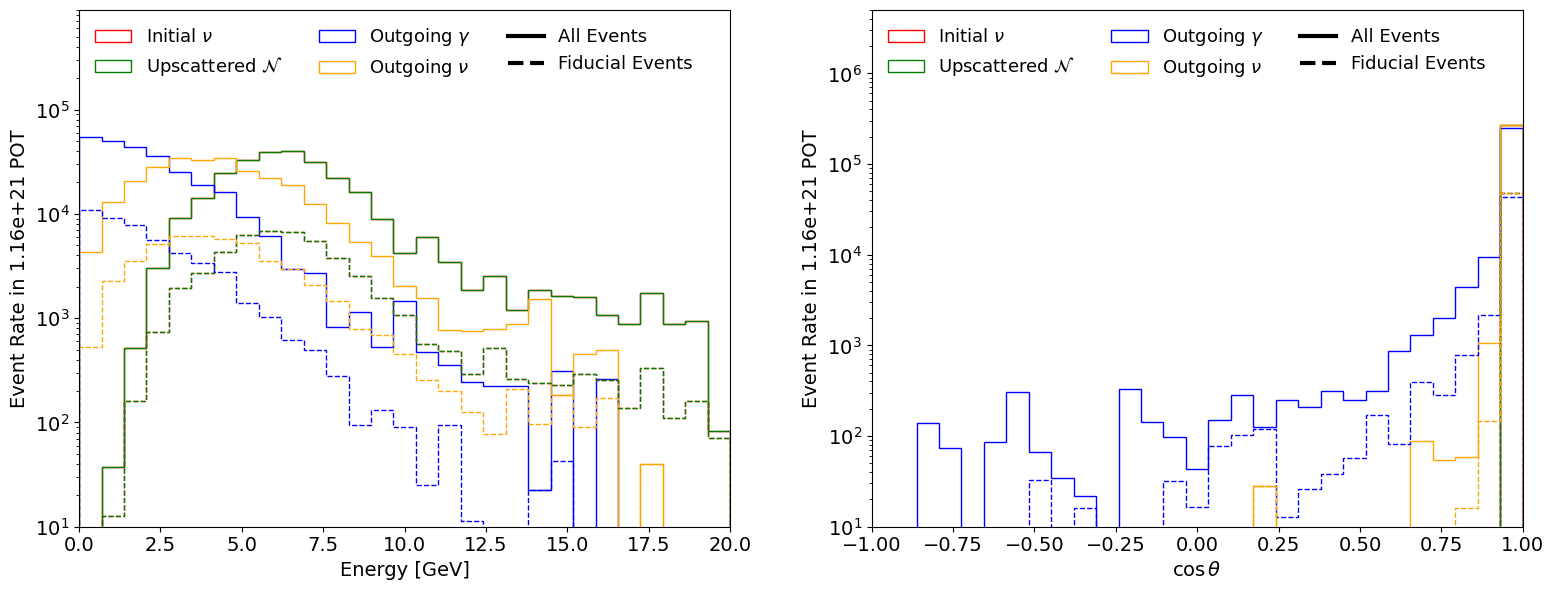

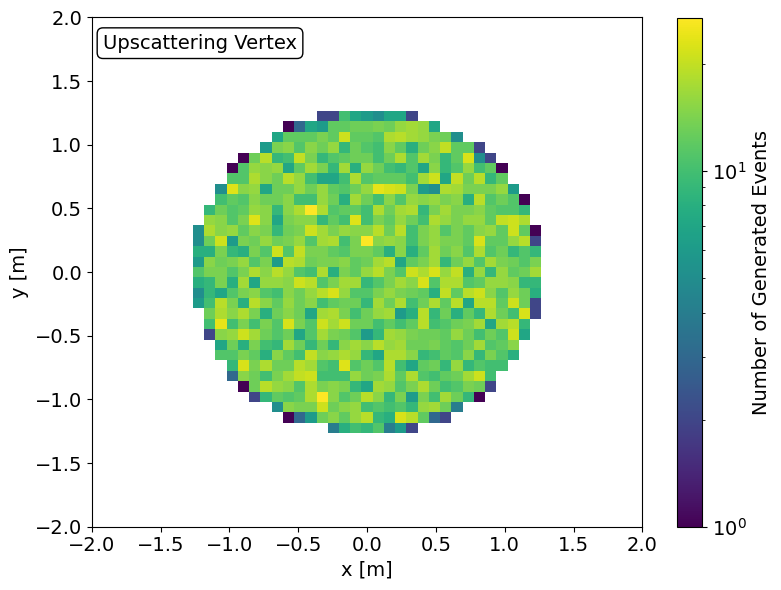

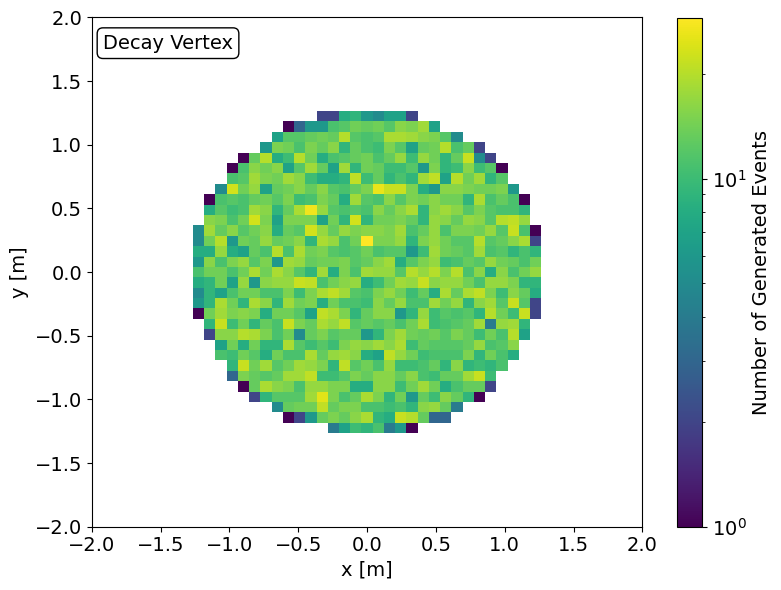

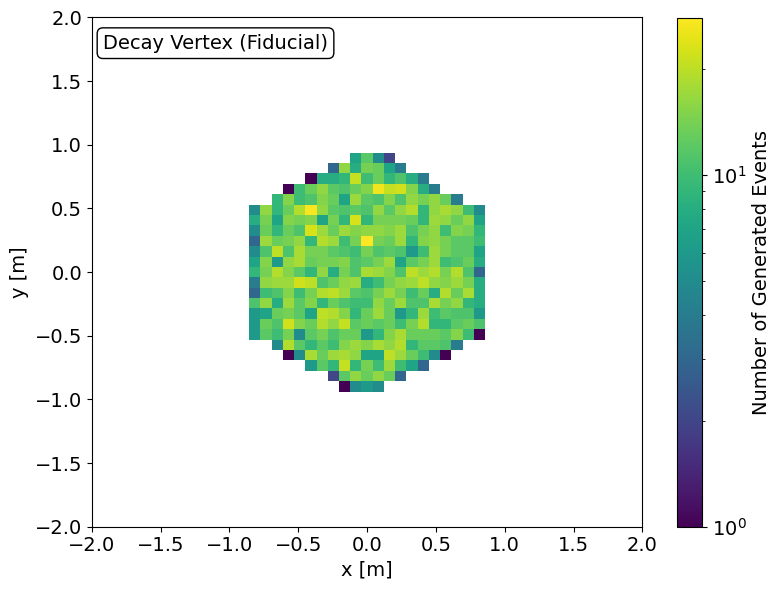

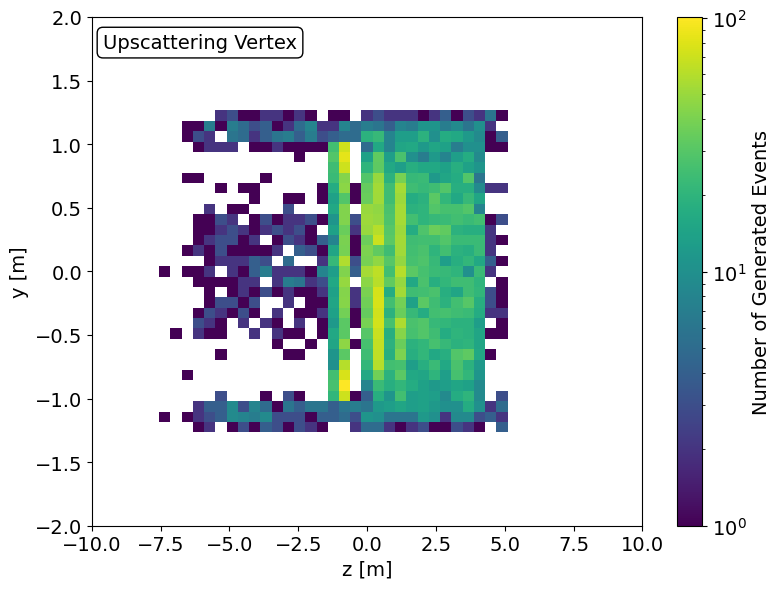

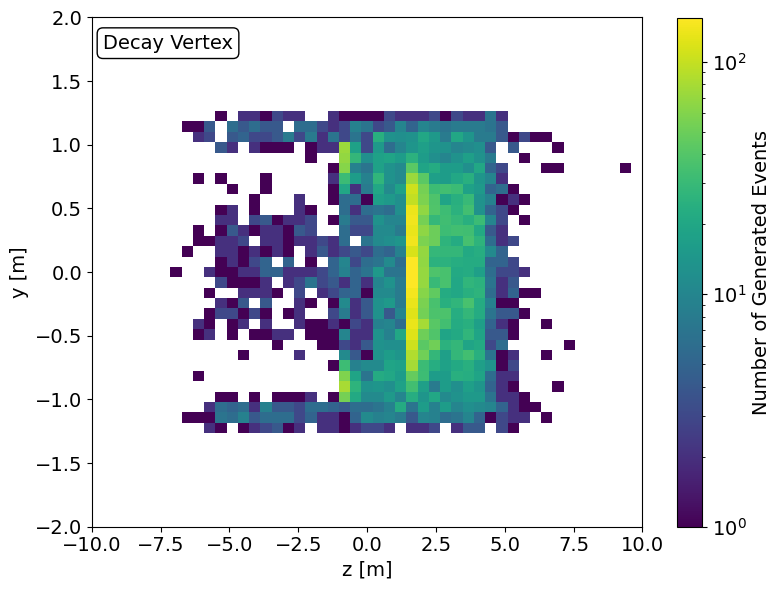

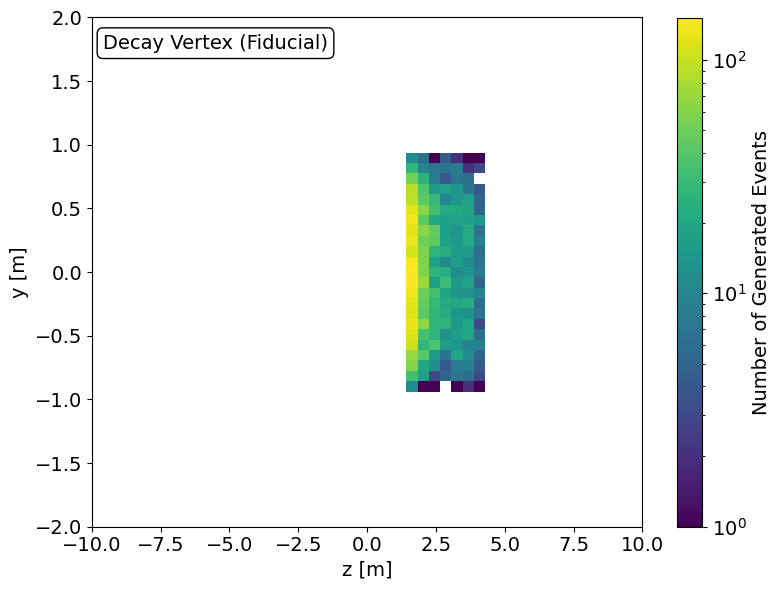

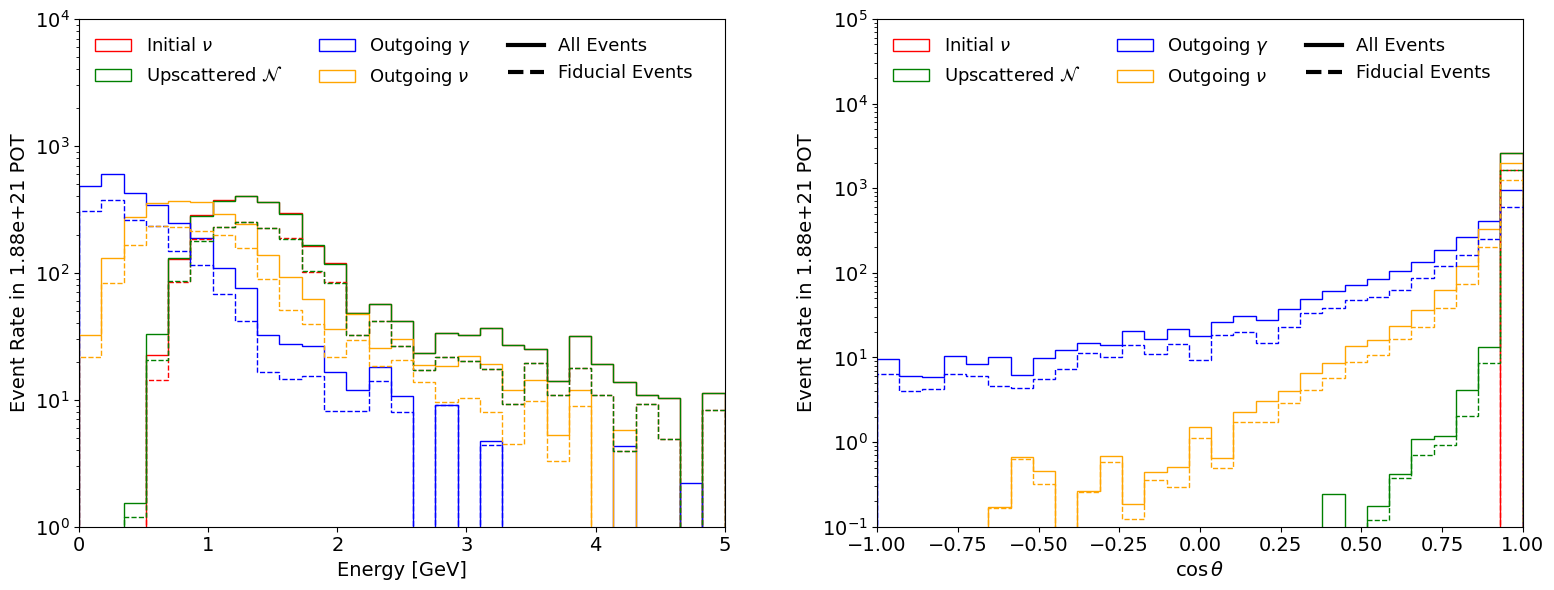

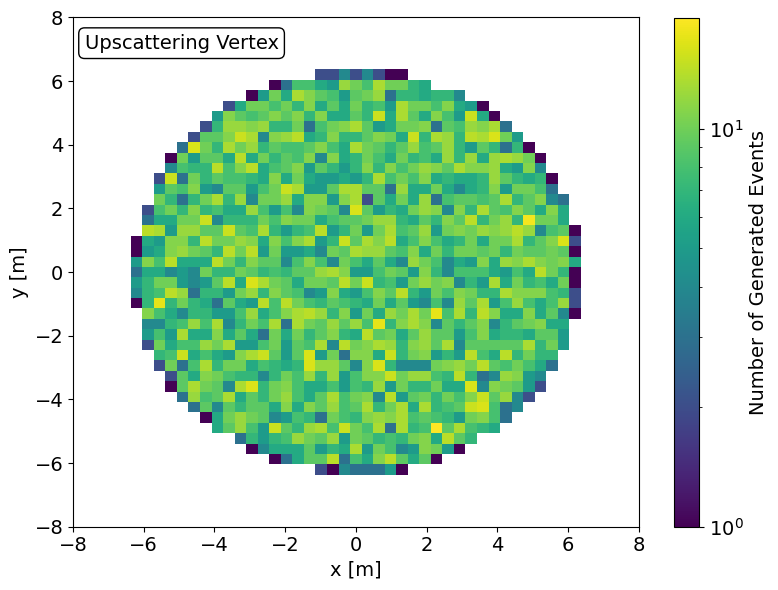

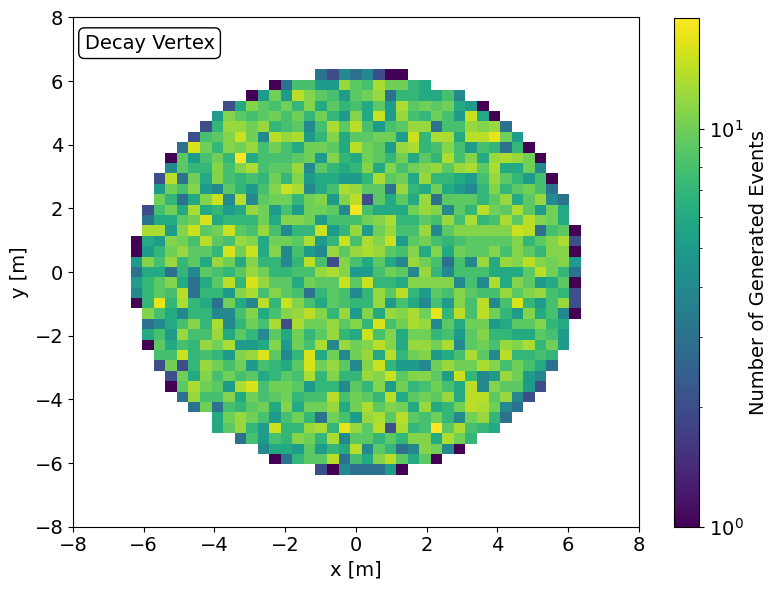

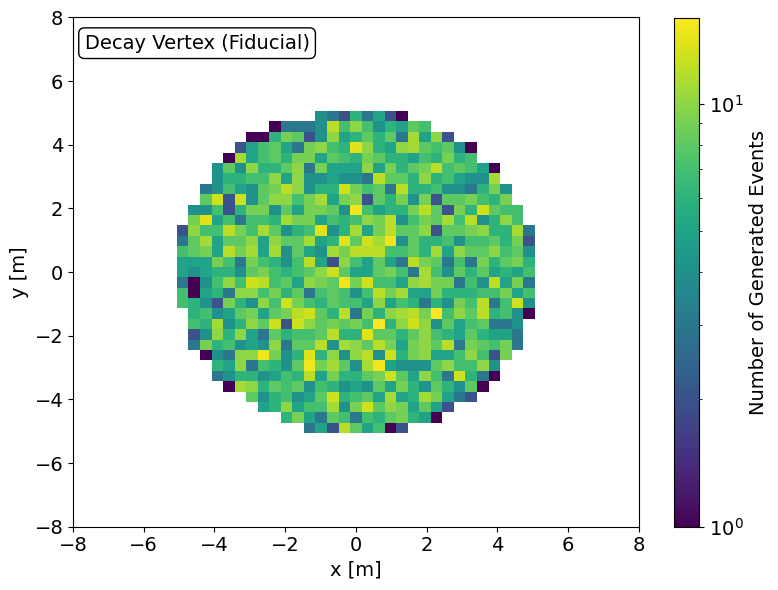

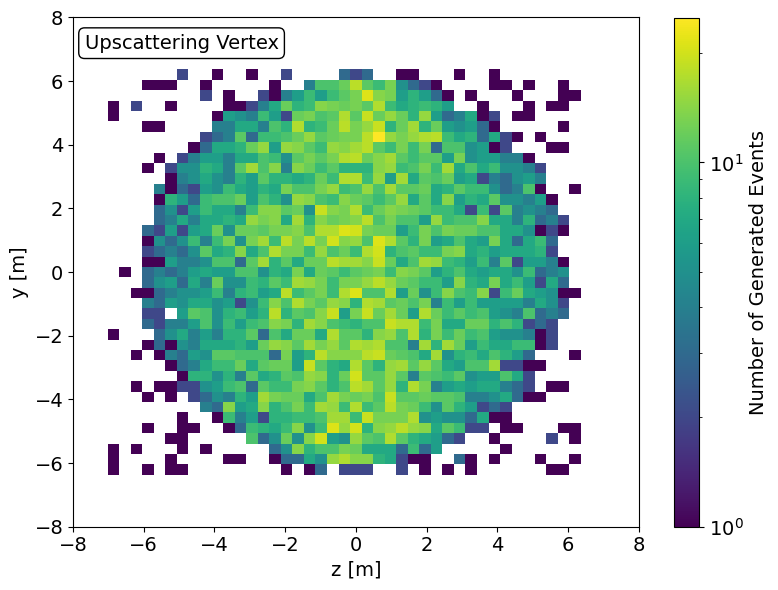

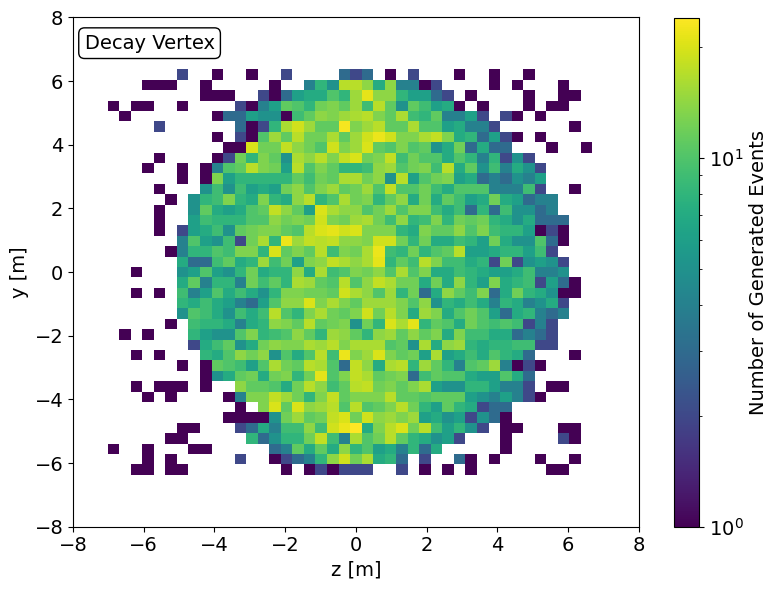

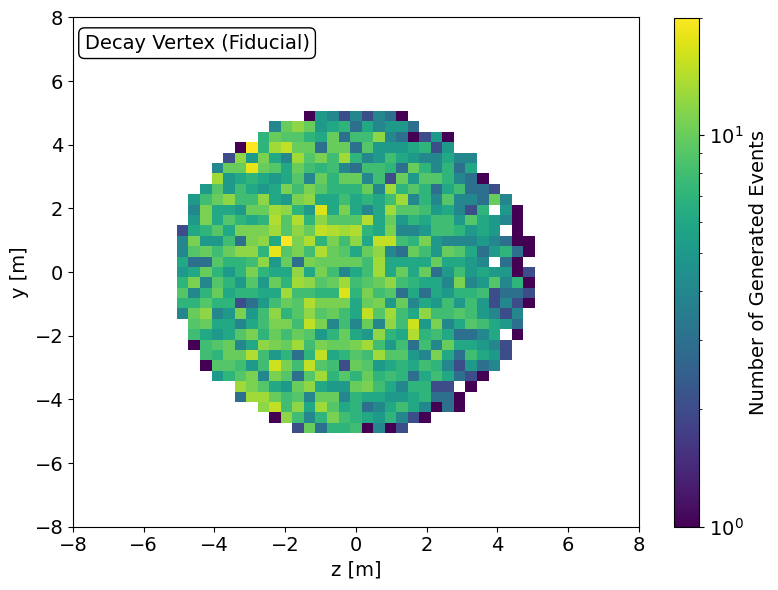

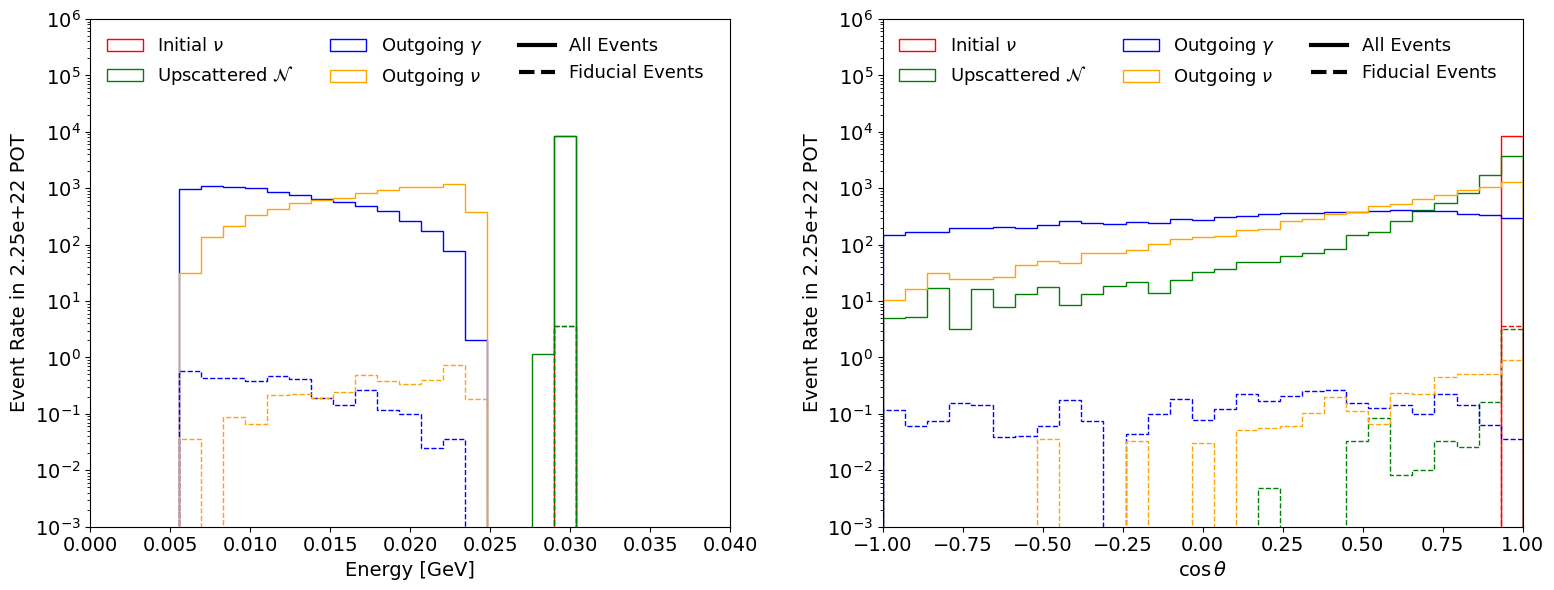

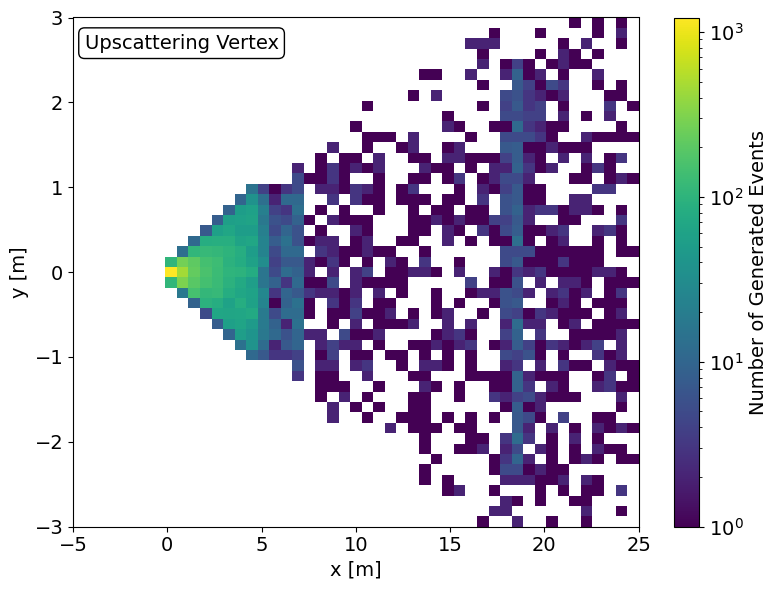

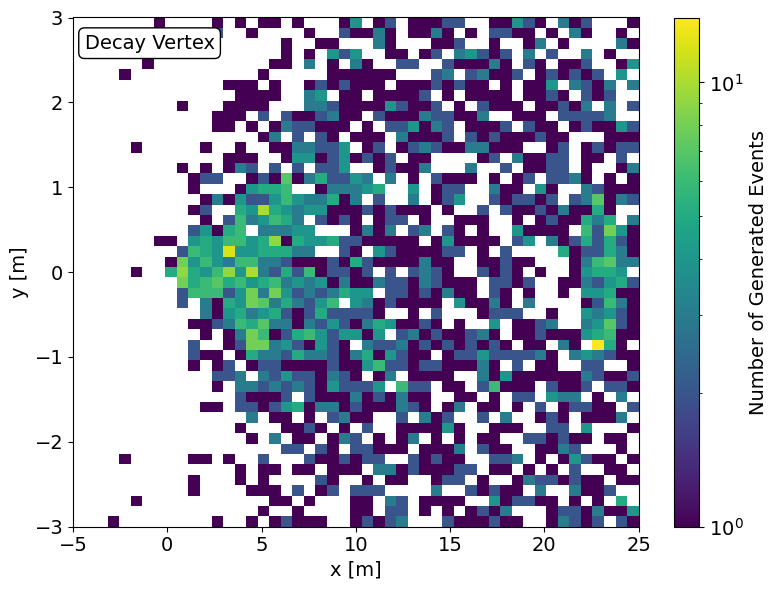

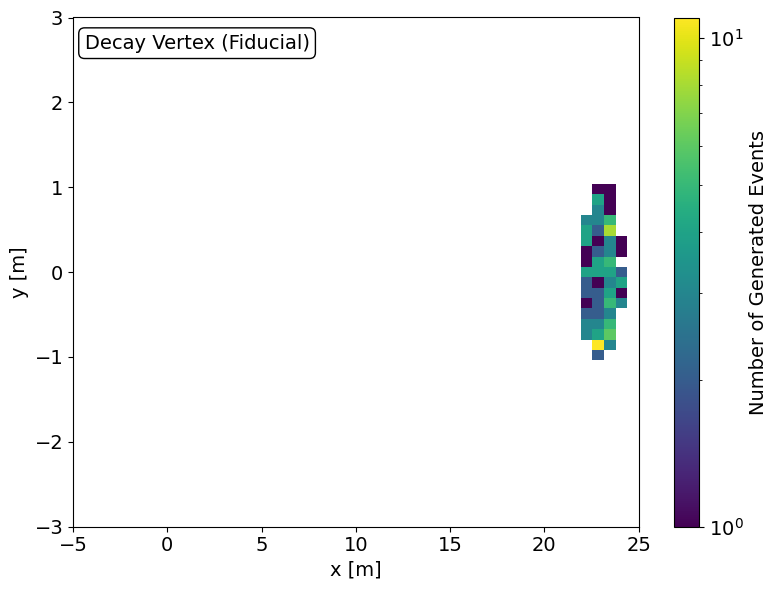

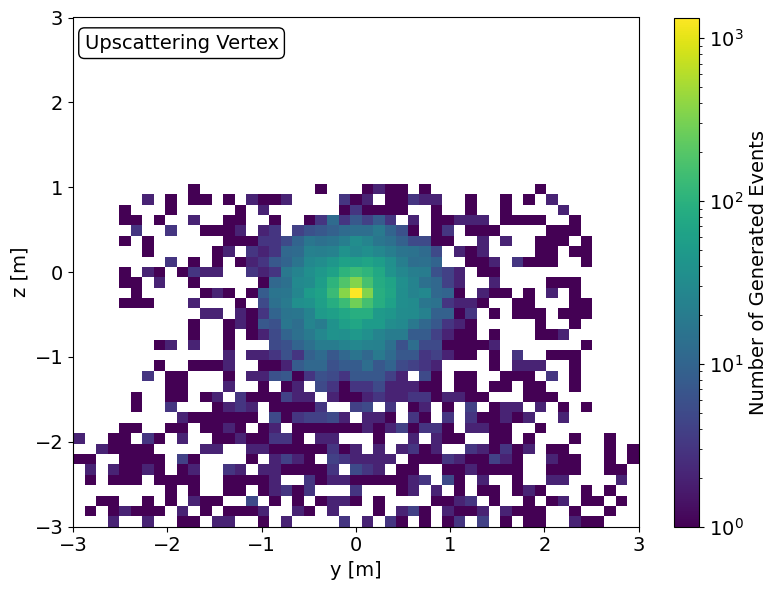

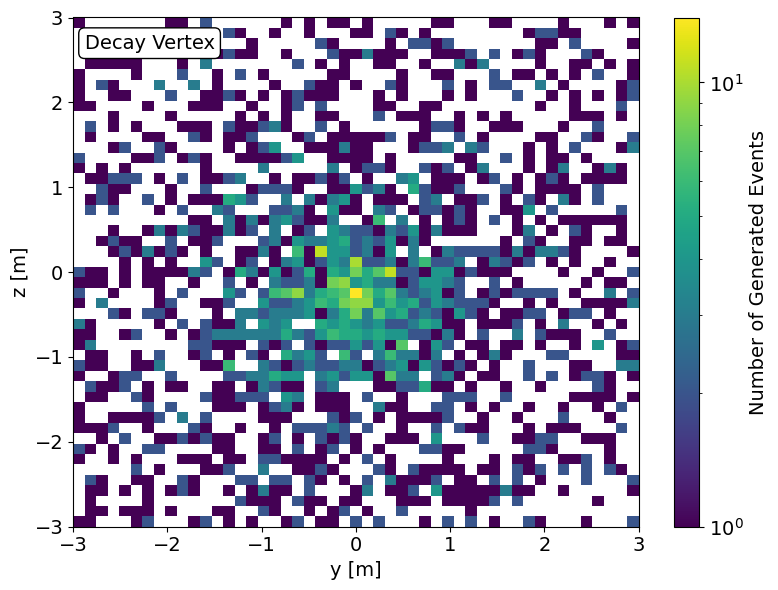

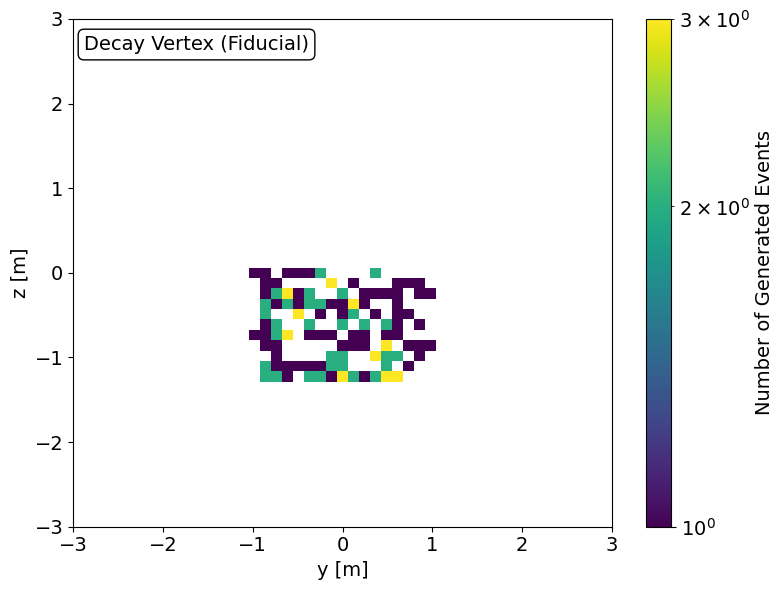

In [5]:
for k in filename.keys():
    data = awk.from_parquet("output/"+filename[k])
    plot_kinematics(data,POT[k],Emax[k],axis[k],ylim_E[k],ylim_C[k],savestr="figures/%s"%k)
    plot_positions(data,xrange[k],yrange[k],savestr="figures/%s"%k)
    if k=="CCM":
        plot_positions(data,yrange[k],zrange[k],"y","z",savestr="figures/%s"%k)
    else:
        plot_positions(data,zrange[k],yrange[k],"z","y",savestr="figures/%s"%k)
        